C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Predicted class: 4
Predicted class mapped: vasc


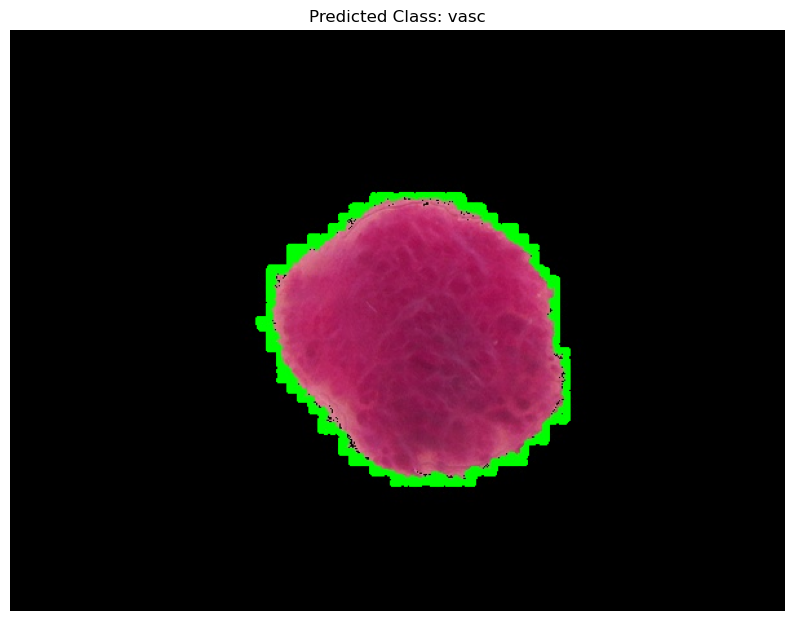

In [50]:
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def extract_contour(color_image):
    hsv_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    return mask

def calculate_border_irregularity(color_image):
    mask = extract_contour(color_image)
    blurred = cv2.GaussianBlur(mask, (5, 5), 0)
    contours, _ = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None

    largest_contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(largest_contour, True)
    area = cv2.contourArea(largest_contour)

    if area == 0:
        return None

    border_irregularity = perimeter ** 2 / (4 * np.pi * area)
    return border_irregularity

def calculate_color_variegation(image):
    skins_r = image[:, :, 2]
    skins_g = image[:, :, 1]
    skins_b = image[:, :, 0]

    mean_r = np.mean(skins_r)
    std_r = np.std(skins_r)
    mean_g = np.mean(skins_g)
    std_g = np.std(skins_g)
    mean_b = np.mean(skins_b)
    std_b = np.std(skins_b)

    C_r = std_r / np.max(skins_r) if np.max(skins_r) != 0 else 0
    C_g = std_g / np.max(skins_g) if np.max(skins_g) != 0 else 0
    C_b = std_b / np.max(skins_b) if np.max(skins_b) != 0 else 0

    color_variegation = (C_r + C_g + C_b) / 3

    return color_variegation, mean_r, std_r, mean_g, std_g, mean_b, std_b

def calculate_diameter(image, dpi=1200):
    mask = extract_contour(image)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0

    max_contour = max(contours, key=cv2.contourArea)
    _, radius = cv2.minEnclosingCircle(max_contour)
    diameter_pixels = 2 * radius
    diameter_physical = diameter_pixels * (25.4 / dpi)

    return diameter_physical

def calculate_asymmetry(binary_image):
    binary_image = binary_image.astype(bool)
    horizontal_flip = np.fliplr(binary_image)
    diff_horizontal = binary_image & ~horizontal_flip
    vertical_flip = np.flipud(binary_image)
    diff_vertical = binary_image & ~vertical_flip
    diff_horizontal_area = np.count_nonzero(diff_horizontal)
    diff_vertical_area = np.count_nonzero(diff_vertical)
    area_total = np.count_nonzero(binary_image)

    if area_total == 0:
        return 0

    asymm_idx = ((diff_horizontal_area / area_total) + (diff_vertical_area / area_total)) / 2
    return asymm_idx

def predict_class(features, model_path, scaler_path):
    # Load model SVM dari file joblib
    svm_model = joblib.load(model_path)

    # Load StandardScaler dari file joblib
    scaler = joblib.load(scaler_path)

    # Transformasi fitur dengan StandardScaler
    features_scaled = scaler.transform([features])

    # Melakukan prediksi kelas menggunakan model SVM
    predicted_class = svm_model.predict(features_scaled)
    return predicted_class[0]

# Path gambar input
input_image = r"C:\Users\Danny\Skripsi\Dataset\data 2\validasi\restore\vasc\ISIC_0032409.jpg"
# Menghitung fitur-fitur dari gambar
image = cv2.imread(input_image)
border_irregularity = calculate_border_irregularity(image)
color_variegation, mean_r, std_r, mean_g, std_g, mean_b, std_b = calculate_color_variegation(image)
diameter = calculate_diameter(image)
asymmetry = calculate_asymmetry(extract_contour(image))

# Menyiapkan fitur-fitur sebagai input untuk model SVM
features = np.array([
    asymmetry,
    border_irregularity,
    color_variegation,
    diameter,
    mean_r,
    std_r,
    mean_g,
    std_g,
    mean_b,
    std_b
])

# Path model SVM (file joblib)
svm_model_path = r"C:\Users\Danny\Skripsi\Dataset\data 2\model\svm_skenario_fix.joblib"

# Path StandardScaler (file joblib)
scaler_path = r"C:\Users\Danny\Skripsi\Dataset\data 2\model\scaler_fix.joblib"

# Prediksi kelas
predicted_class = predict_class(features, svm_model_path, scaler_path)
print(f"Predicted class: {predicted_class}")

# Mapping kelas
class_map = {'akiec': 0, 'df': 1, 'nv': 2, 'mel': 3, 'vasc': 4}

# Memetakan prediksi kelas berdasarkan class_map
predicted_class_mapped = list(class_map.keys())[list(class_map.values()).index(predicted_class)]
print(f"Predicted class mapped: {predicted_class_mapped}")

# Menampilkan hasil deteksi
mask = extract_contour(image)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {predicted_class_mapped}')
plt.axis('off')
plt.show()


In [54]:
import pandas as pd

# Baca file CSV
input_csv = r"C:\Users\Danny\Skripsi\Dataset\data 2\file csv\skripsi.csv"
df = pd.read_csv(input_csv)

# Pastikan bahwa file CSV memiliki kolom 'Class' yang menunjukkan kelas dari setiap data
# Gantilah 'Class' dengan nama kolom yang sesuai di file CSV Anda

# Pilih 20 data unik dari masing-masing kelas
unique_data = []
classes = df['Class'].unique()

for class_name in classes:
    class_data = df[df['Class'] == class_name]
    if len(class_data) > 200:
        class_data = class_data.sample(200, random_state=42)
    unique_data.append(class_data)

# Gabungkan data dari semua kelas menjadi satu DataFrame
unique_data = pd.concat(unique_data)

# Simpan hasil ke file CSV baru
output_csv = r"C:\Users\Danny\Skripsi\Dataset\data 2\file csv\skripsi_trial2.csv"
unique_data.to_csv(output_csv, index=False)

print(f"Data unik disimpan di {output_csv}")


Data unik disimpan di C:\Users\Danny\Skripsi\Dataset\data 2\file csv\skripsi_trial2.csv
